## A.3: Final Report: SOTU

### Load Libraries

In [1]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import os
wd = os.getcwd()
wd_new = wd +'/nltk_data' #creating a new working directory path for stopwords files

import nltk
nltk.download('stopwords',download_dir=wd_new) 
nltk.download('wordnet',download_dir=wd_new)
nltk.data.path.append(wd_new)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aliagowani/Documents/GitHub/NU_453_NLP/nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aliagowani/Documents/GitHub/NU_453_NLP/nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Functionality to turn stemming on or off
STEMMING = False
NGRAM_LENGTH = 2

#### Pandas Parameters

In [3]:
#pandas parameters
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Function to process documents

In [5]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    file_stopwords = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/english",header=None)
    file_stopwords = file_stopwords[0].values.tolist()
    new_stopwords = ['effect','years','great','today','tonight','congress','freedom','united','states','united states','americans','america','american','americas','government','people','world','shall','would','nations','national','nation'] #remove repeating terms
    new_stopwords= new_stopwords+file_stopwords
    stop_words = stop_words.union(new_stopwords)
    tokens = [w for w in tokens if not w in stop_words]        
    # word stemming    
    #if STEMMING:
        #ps=PorterStemmer()
        #tokens=[ps.stem(word) for word in tokens]
    # Lemmatization to account for things like plurals
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(token) for token in tokens]
    
    return tokens

###   Functions to label encoding

In [6]:
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

In [7]:
# read data
data = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/sotu_corpus_small.csv")


In [8]:
# new data frame with split value columns 
new = data["DSI_Title"].str.split("_", n = 1, expand = True) 
  
# making separate President_Name column from new data frame 
data["President_Name"] = new[0] 
  
# making separate Year_SOTU column from new data frame 
data["Year_SOTU"] = new[1] 
  
new = data["Year_SOTU"].str.split(".", n = 1, expand = True) 
data["Year_SOTU"] = new[0] 

# df display 
data.shape
data.head(5) 

(102, 5)

,Unnamed: 0,DSI_Title,Text,President_Name,Year_SOTU
0,0,Reagan_1982.txt,"Mr. Speaker, Mr. President, distinguished Memb...",Reagan,1982
1,1,Wilson_1914.txt,GENTLEMEN OF THE CONGRESS: The session upon w...,Wilson,1914
2,2,Madison_1814.txt,Fellow-Citizens of the Senate and House of Rep...,Madison,1814
3,3,Johnson_1969.txt,"Mr. Speaker, Mr. President, Members of the Con...",Johnson,1969
4,4,Hoover_1930.txt,To the Senate and House of Representatives: I...,Hoover,1930


### Processing text into lists

In [9]:
# create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

In [10]:
# create empty list to store text documents
text_body=[]

# for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

# Note: the text_body is the unprocessed list of documents read directly form the csv.

In [12]:
# empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

In [13]:
# stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)

In [14]:
# Length of full tokenized corpus
len(temp_text)

25293

### Sklearn TFIDF 
note the ngram_range will allow you to include multiple words within the TFIDF matrix

In [15]:
# Call Tfidf Vectorizer
#Tfidf=TfidfVectorizer(ngram_range=(1,2), min_df=0.1, max_df=0.80)#, max_features=50000)
#Tfidf=TfidfVectorizer(ngram_range=(1,4),max_df=0.80)#, max_features=50000)
Tfidf=TfidfVectorizer(ngram_range=(1,3), max_df=0.80, max_features=50000)


#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

In [16]:
# Verify TFIDF_Matrix has been created.
matrix.shape
matrix.head()

(102, 50000)

,abandon,abandon iraqi,abandoned,abandoning,abandonment,abatement,abdicated,abdication,abide,abiding,ability,ability compete,ability negotiate,ability president,abject,ablebodied,aboard,abolish,abolished,abolishing,abolition,abolition slavery,abortion,abortion human,abounds,abraham,abraham lincoln,abraham lincoln warned,abridged,abroad,abroad order,abroad strength,abroad strong,absence,absence appropriation,absolute,absolutely,absolutely clear,absolutely vital,absorb,absorbed,absorption,abstinence,abstract,abundance,abundant,abundant fruit,abundantly,abundantly clear,abuse,abuse grown,abuse place,abuse result,abused,academy,academy point,accede,acceded,accelerate,accelerated,accelerating,acceleration,accept,accept change,accept responsibility,acceptable,acceptance,acceptance volunteer,accepted,accepted peace,accepting,access,access coverage,access market,access opportunity,accessible,accident,accidental,accommodate,accommodating,accommodation,accommodation president,accommodation provided,accompanied,accompany,accomplish,accomplish object,accomplish purpose,accomplish thing,accomplished,accomplishing,accomplishing object,accomplishing purpose,accomplishment,accomplishment decade,accord,accordance,accordance interpretation,accordance interpretation treaty,accorded,account,account district,account district columbia,account money,account receipt,account receipt expenditure,account younger,account younger worker,accountability,accountability result,accountable,accounted,accounted material,accounted material evidence,accounting,accredited,accrue,accrued,accrued exceeds,accruing,accruing business,accumulate,accumulated,accumulating,accumulation,accumulation surplus,accumulation surplus revenue,accuracy,accurate,accurately,accused,accused crime,accustomed,achieve,achieve continue,achieve dream,achieve energy,achieve energy goal,achieve energy independence,achieve future,achieve goal,achieve greater,achieve historic,achieve peace,achieve result,achieve thing,achieved,achieved greatest,achievement,achievement ahead,achievement failure,achievement patriotic,achievement purpose,achieving,achieving balanced,achieving balanced budget,achieving energy,achieving energy independence,achieving peace,acknowledge,acknowledged,acknowledged provided,acknowledgement,acknowledging,acknowledgment,acknowledgment supreme,acquainted,acquiescence,acquire,acquire force,acquired,acquires,acquiring,acquisition,acre,acted,acting,acting article,acting article treaty,acting authority,action,action action,action behalf,action called,action complete,action completed,action deemed,action demand,action demanded,action ensure,action europe,action executive,action federal,action force,action improve,action increase,action matter,action measure,action necessity,action needed,action policy,action power,action president,action program,action proper,action protect,action reduce,action reform,action required,action responsibility,action senate,action session,action vital,action word,active,active defense,active force,active service,actively,actively engaged,activist,activist judge,activity,activity complete,activity department,activity important,actual,actual estimated,actual experience,actual payment,actual reduction,actual remaining,actual remaining quarter,actual service,actuated,acute,acutely,acutely affected,adam,adapt,adapted,adapted principle,adapting,added,added million,addict,addicted,addiction,adding,addition,...,westward,wewill,wewill choose,wewill choose place,whats,whatsoever,wheat,wheel,whilst,whilst public,whilst public expenditure,white,white house,white house december,white house february,wholehearted,wholesale,wholesale dealer,wholesale price,wholesome,wholly,whove,wibberley,wicked,widely,widely shared,widely shared prosperity,widen,widening,wider,wider enjoyment,wider field,widespread,widespread hardship,widow,wilderness,wildlife,wilful,wilful deception,wilful deception deceive,willingly,willingness,wilson,wind,wind change,windfall,windfall profit,wind

In [17]:
# Get unique names of President_Name to ensure BushW and BusHW were enetered correctly.
data['President_Name'].unique()

array(['Reagan', 'Wilson', 'Madison', 'Johnson', 'Hoover', 'Roosevelt',
       'Truman', 'Kennedy', 'Jefferson', 'Monroe', 'Trump', 'Eisenhower',
       'Obama', 'Adams', 'BushHW', 'Cleveland', 'Grant', 'Washington',
       'Ford', 'BushW', 'Nixon', 'Carter', 'Arthur'], dtype=object)

(<Figure size 1368x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a22fc3d10>)

Text(0.5, 0, 'President Name')

Text(0, 0.5, 'Count of SOTU')

Text(0.5, 1.0, 'US: State of the Union Speeches (SOTU)')

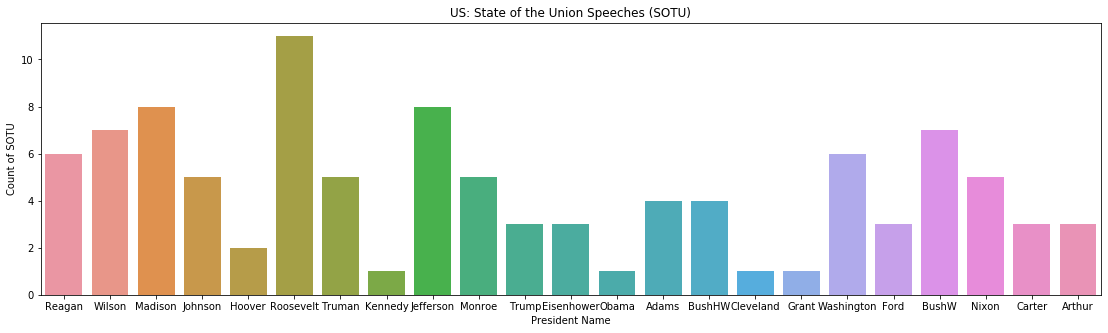

In [18]:
# Simple plot to show the number of SOTU speeches by President Name

import seaborn as sns

plt.subplots(figsize=(19,5))
ax = sns.countplot(x="President_Name", data=data)
# plt.savefig("plot-president_name.pdf", bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', orientation='portrait', papertype=None, format=None, pad_inches=0.25)
plt.xlabel('President Name')
plt.ylabel('Count of SOTU')
plt.title('US: State of the Union Speeches (SOTU)')
plt.show()

### Explore Frequent Terms

In [19]:
# Creating dataframe from CV Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,3))
cv_matrix=cv.fit_transform(final_processed_text)    
cv_matrix=pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names(), index=titles)   

In [20]:
# Trying few things out (Ali) 

# Create transposed dataframe from CV Matrix
matrix_corp_t = matrix.transpose()
cv_matrix_corp_t = cv_matrix.transpose() 

# Sum all the terms to create Term Frequency and Document Frequency for each term
cv_matrix_corp_t['df_corpus']= (cv_matrix_corp_t != 0).sum(axis=1)
cv_matrix_corp_t['tf_corpus']= cv_matrix_corp_t.sum(axis=1) - cv_matrix_corp_t['df_corpus']

# Remove uncessary columns from the dataframe after summing them
idx = np.r_[0:102]
cv_matrix_corp_t.drop(cv_matrix_corp_t.columns[idx], axis=1, inplace=True)

print("Top 10 Terms based on document frequency.")
print(cv_matrix_corp_t[['df_corpus']].nlargest(20, 'df_corpus'))
print("\n")
print("Top 10 Terms based on frequency.")
print(cv_matrix_corp_t[['tf_corpus']].nlargest(20, 'tf_corpus'))

Top 10 Terms based on document frequency.
           df_corpus
state             98
power             97
peace             95
force             93
interest          93
public            93
policy            90
citizen           89
progress          89
system            89
future            86
present           86
service           86
mean              85
place             85
important         83
military          83
security          83
house             82
purpose           82


Top 10 Terms based on frequency.
          tf_corpus
peace           709
power           533
program         482
public          479
force           463
security        433
citizen         421
federal         413
million         408
economic        399
future          385
state           384
interest        378
system          343
defense         331
present         328
economy         324
military        320
effort          315
policy          315


### Explore TFIDF Values

In [21]:
average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)

#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]

In [22]:
outlier_list.shape

(5691, 1)

### Doc2Vec

In [23]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

### Gensim Word2vec 
Note, there are opportunities to use the word2vec matrix to determine words which are similar.  Similar words can be used to create equivalent classes.  
k-means is not used to group individual words using the Word2Vec output.

In [24]:
#word to vec
model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

### K Means Clustering - TFIDF
the following section runs applies the k-means algorithm on the TFIDF matrix.

[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
        n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
        n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
        n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
        n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
        n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorit

[-92.52386327946517,
 -88.4052500511212,
 -86.56432220928039,
 -85.0967694011929,
 -83.87207187885424,
 -82.64566263100615,
 -81.11248285024627]

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Elbow Method')

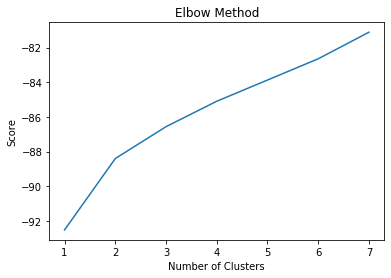

In [25]:
number_clusters = range(1, 8)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(TFIDF_matrix).score(TFIDF_matrix) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [26]:
k=6
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])


print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=89, tol=0.0001, verbose=0)

Top terms per cluster:
Cluster 0:


(None,)

economic
 program
 production
 democracy
 action
 effort
 defense
 price
 strength
 problem
 business
 thing
 people
 legislation
 income
Cluster 0 titles: Wilson_1914.txt, Wilson_1917.txt, Roosevelt_1938.txt, Truman_1949.txt, Truman_1948.txt, Wilson_1913.txt, Roosevelt_1939.txt, Eisenhower_1959.txt, Eisenhower_1958.txt, Roosevelt_1940.txt, Roosevelt_1941.txt, Roosevelt_1943.txt, Roosevelt_1942.txt, Roosevelt_1944.txt, Eisenhower_1957.txt, Roosevelt_1937.txt, Truman_1952.txt, Wilson_1920.txt, Roosevelt_1936.txt, Truman_1951.txt, Truman_1950.txt, Wilson_1918.txt, Johnson_1965.txt, Johnson_1964.txt,Cluster 1:


(None,)

program
 federal
 budget
 billion
 soviet
 family
 child
 president
 spending
 economic
 growth
 percent
 inflation
 reform
 nuclear
Cluster 1 titles: Reagan_1982.txt, Johnson_1969.txt, Johnson_1968.txt, Reagan_1984.txt, Reagan_1985.txt, Reagan_1987.txt, Kennedy_1963.txt, Reagan_1986.txt, BushHW_1992.txt, BushHW_1991.txt, BushHW_1990.txt, BushHW_1989.txt, Ford_1976.txt, Ford_1977.txt, Ford_1975.txt, Nixon_1972.txt, Nixon_1973.txt, Reagan_1988.txt, Nixon_1971.txt, Nixon_1970.txt, Carter_1980.txt, Johnson_1966.txt, Nixon_1974.txt, Carter_1978.txt, Carter_1979.txt, BushW_2001.txt,Cluster 2:


(None,)

treaty
 spain
 gentleman
 commissioner
 indian
 subject
 provision
 object
 commerce
 majesty
 article
 measure
 minister
 proper
 consideration
Cluster 2 titles: Monroe_1820.txt, Adams_1799.txt, Adams_1798.txt, Monroe_1819.txt, Grant_1872.txt, Monroe_1818.txt, Washington_1791.txt, Adams_1800.txt, Washington_1793.txt, Washington_1792.txt, Washington_1796.txt, Washington_1795.txt, Adams_1797.txt, Washington_1794.txt, Arthur_1883.txt, Arthur_1882.txt, Arthur_1881.txt,Cluster 3:


(None,)

relief
 industrial
 tariff
 recovery
 economic
 federal
 price
 employment
 condition
 interstate
 depression
 labor
 action
 expenditure
 method
Cluster 3 titles: Hoover_1930.txt, Hoover_1932.txt, Wilson_1916.txt, Cleveland_1887.txt, Roosevelt_1934.txt, Roosevelt_1935.txt, Wilson_1919.txt,Cluster 4:


(None,)

terrorist
 iraqi
 child
 terror
 worker
 regime
 woman
 economy
 health
 reform
 weapon
 afghanistan
 family
 immigration
 border
Cluster 4 titles: Trump_2017.txt, Obama_2016.txt, Trump_2019.txt, Trump_2018.txt, BushW_2005.txt, BushW_2004.txt, BushW_2006.txt, BushW_2007.txt, BushW_2003.txt, BushW_2002.txt,Cluster 5:


(None,)

british
 vessel
 commerce
 million
 subject
 militia
 treasury
 consideration
 tribe
 enemy
 provision
 object
 circumstance
 legislature
 officer
Cluster 5 titles: Madison_1814.txt, Madison_1815.txt, Madison_1816.txt, Madison_1812.txt, Madison_1813.txt, Madison_1811.txt, Jefferson_1808.txt, Madison_1810.txt, Monroe_1822.txt, Monroe_1817.txt, Madison_1809.txt, Jefferson_1805.txt, Jefferson_1804.txt, Jefferson_1806.txt, Jefferson_1807.txt, Jefferson_1803.txt, Jefferson_1802.txt, Jefferson_1801.txt,

### Plotting 
Convert two components as we're plotting points in a two-dimensional plane
"precomputed" because we provide a distance matrix

We will also specify `random_state` so the plot is reproducible.

In [27]:
%matplotlib inline


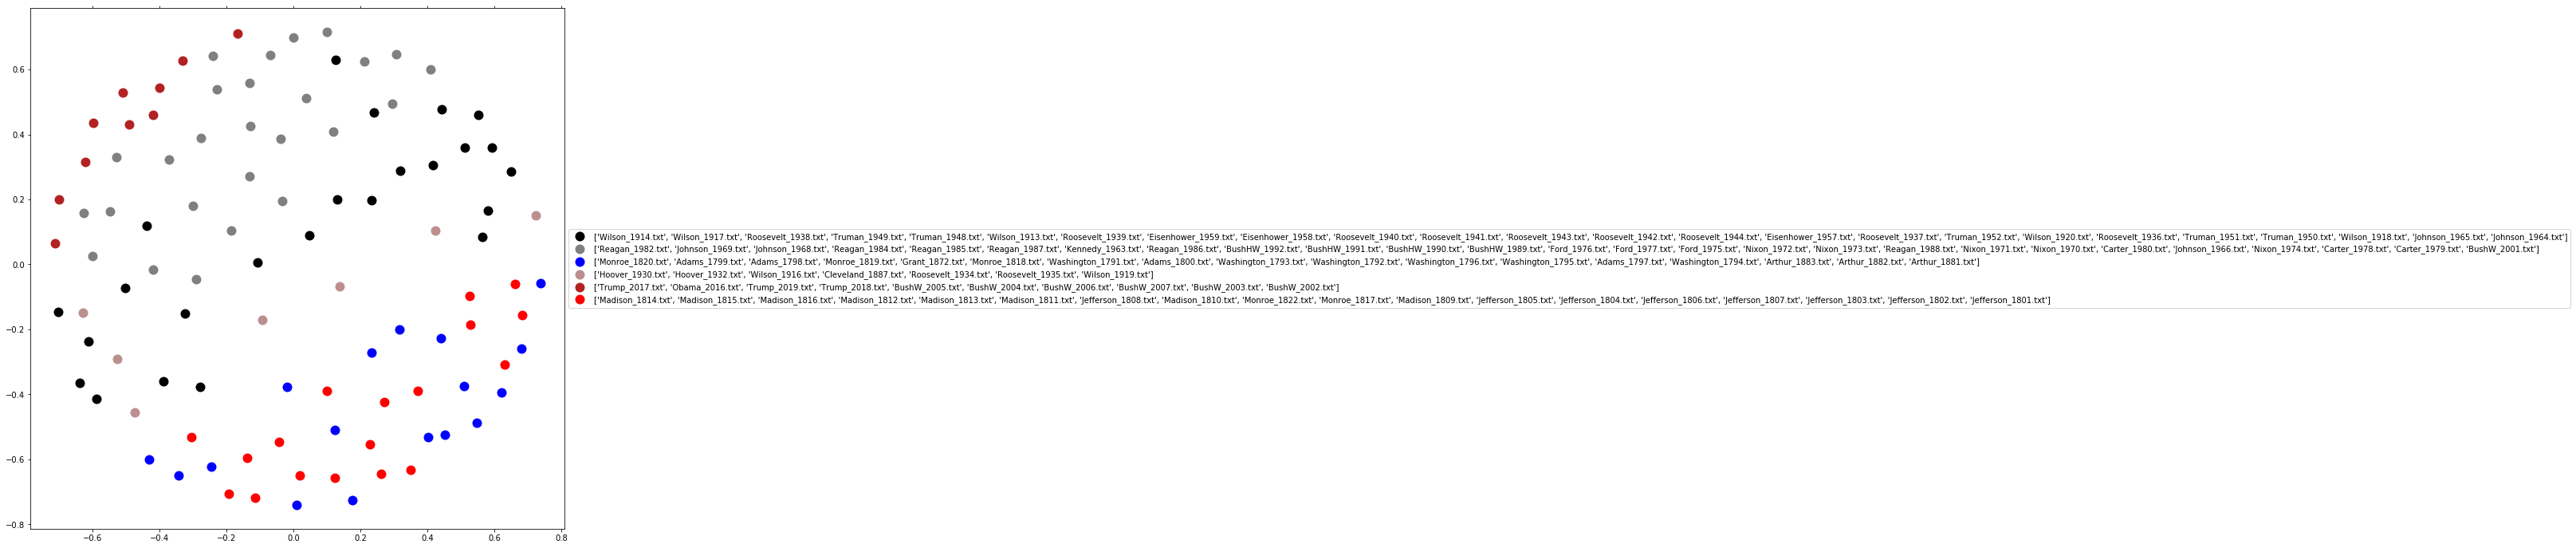

In [28]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 5:'red', 6:'darksalmon', 7:'sienna', 8:'green', 9:'purple', 10:'pink', 11:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

In [29]:
#fig.savefig('Images/clusters.png')

### Review Clusters

In [30]:
term_clusters = pd.DataFrame.from_dict(cluster_terms) #pull out terms into a dataframe
terms = term_clusters.stack() #stack terms names into 1 column
terms = terms.reset_index() #move index into a column
terms = terms.rename(columns={'level_1': 'cluster_term', 0:'term'}) #rename columns
terms = terms.drop(['level_0'], axis=1) #drop unecessary column
terms.head()

,cluster_term,term
0,0,economic
1,1,program
2,2,treaty
3,3,relief
4,4,terrorist


In [31]:
# look at frequent terms across clusters
term_clusters

,0,1,2,3,4,5
0,economic,program,treaty,relief,terrorist,british
1,program,federal,spain,industrial,iraqi,vessel
2,production,budget,gentleman,tariff,child,commerce
3,democracy,billion,commissioner,recovery,terror,million
4,action,soviet,indian,economic,worker,subject
5,effort,family,subject,federal,regime,militia
6,defense,child,provision,price,woman,treasury
7,price,president,object,employment,economy,consideration
8,strength,spending,commerce,condition,health,tribe
9,problem,economic,majesty,interstate,reform,enemy


In [32]:
titles = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
titles = titles.stack() #stack document names into 1 column
titles = titles.reset_index() #move index into a column
titles = titles.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
titles = titles.drop(['level_1'], axis=1) #drop unecessary column
titles.head()

,cluster_doc,document
0,0,Wilson_1914.txt
1,0,Wilson_1917.txt
2,0,Roosevelt_1938.txt
3,0,Truman_1949.txt
4,0,Truman_1948.txt


In [33]:
# join TFIDF values to documents in new dataframe w/ clusters
term_list = terms['term'].values.tolist() #pull all terms into a list
matrix_clustering = matrix[term_list] #pull out only terms in clusters
full_titles = titles.set_index('document').join(matrix_clustering, how='left') # join in tf-idf values
full_titles.shape

(102, 91)

In [34]:
# calculate average tf-idf values for each cluster of terms
for i in range (k):
    full_titles[i] = full_titles[term_clusters[i].values.tolist()].mean(axis=1)

In [35]:
# remove all other columsn leaving only the average 
full_titles = full_titles.set_index('cluster_doc', append=True)
full_titles_final = full_titles[full_titles.columns[-k:]]

<Figure size 360x2160 with 0 Axes>

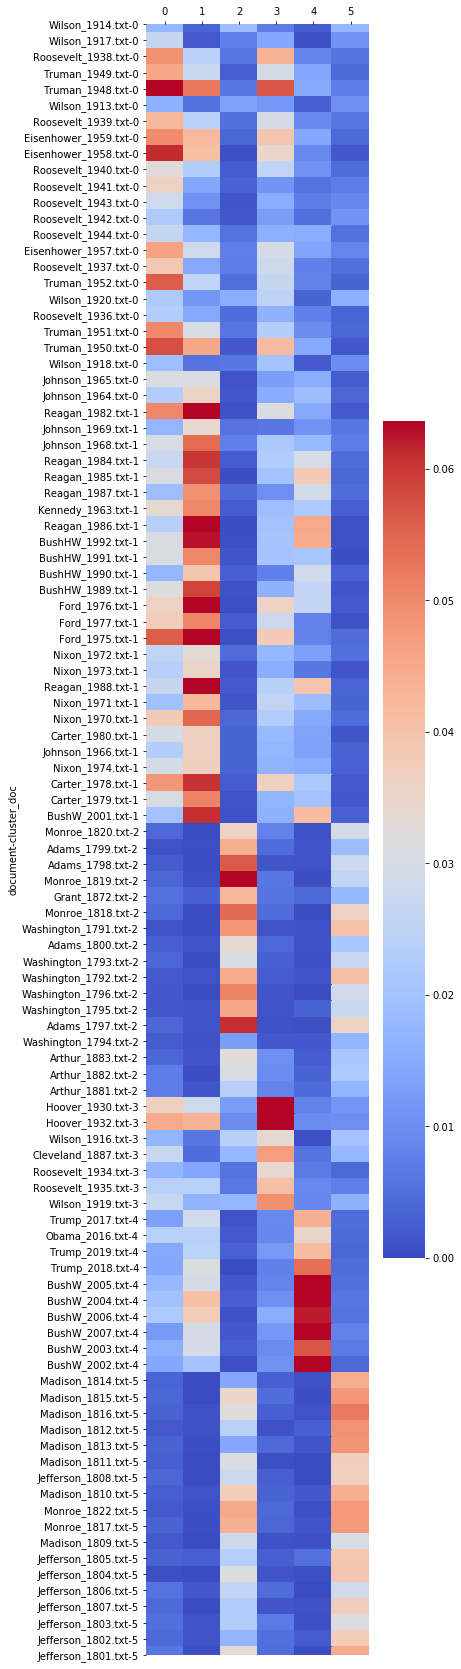

In [36]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(5,30))
plt.rcParams['font.size'] = 10
p=sns.heatmap(full_titles_final, cmap='coolwarm', robust=True)
p.xaxis.tick_top()
p.xaxis.set_label_position('top')

In [41]:
p.get_figure().savefig('Images/heatmap_7.png')

# heatmap_1 using 8 clusters, no additional stopwords removed
# heatmap_2 using 8 clusters, reduced term size to 1-2 words, removed frequent words
# heatmap_3 using 6 clusters, reduced term size to 1-2 words, removed frequent words
# heatmap_4 using 6 clusters, reduced term size to 1-3 words, removed frequent words
# heatmap_5 using 6 clusters, reduced term size to 1-2 words, removed frequent words, increased top term size to 15 *BEST*
# heatmap_6 using 6 clsuters, reduced term size to 1-2 words, removed frequent words, increased top term size to 20
# heatmap_7 using 6 clsuters, term size to 1-3 words, removed frequent words, top term size 15

##### Look at terms that show up in all documents

In [42]:
matrix_copy = matrix.copy() #copy dataframe
matrix_copy = matrix_copy.T  #transpose

matrix_copy[(matrix_copy != 0).all(1)] # pull terms that show up in all documents


,Reagan_1982.txt,Wilson_1914.txt,Madison_1814.txt,Johnson_1969.txt,Hoover_1930.txt,Johnson_1968.txt,Madison_1815.txt,Wilson_1917.txt,Hoover_1932.txt,Madison_1816.txt,Wilson_1916.txt,Reagan_1984.txt,Roosevelt_1938.txt,Madison_1812.txt,Truman_1949.txt,Truman_1948.txt,Madison_1813.txt,Wilson_1913.txt,Roosevelt_1939.txt,Reagan_1985.txt,Reagan_1987.txt,Madison_1811.txt,Kennedy_1963.txt,Jefferson_1808.txt,Madison_1810.txt,Reagan_1986.txt,Monroe_1820.txt,Trump_2017.txt,Eisenhower_1959.txt,Obama_2016.txt,Adams_1799.txt,Adams_1798.txt,Eisenhower_1958.txt,Monroe_1822.txt,BushHW_1992.txt,Monroe_1819.txt,Cleveland_1887.txt,BushHW_1991.txt,BushHW_1990.txt,Grant_1872.txt,Monroe_1818.txt,Roosevelt_1940.txt,BushHW_1989.txt,Washington_1791.txt,Roosevelt_1941.txt,Adams_1800.txt,Roosevelt_1943.txt,Washington_1793.txt,Washington_1792.txt,Roosevelt_1942.txt,Monroe_1817.txt,Ford_1976.txt,Washington_1796.txt,Trump_2019.txt,Trump_2018.txt,Ford_1977.txt,Ford_1975.txt,Washington_1795.txt,Adams_1797.txt,Washington_1794.txt,Roosevelt_1944.txt,Eisenhower_1957.txt,BushW_2005.txt,Roosevelt_1937.txt,Madison_1809.txt,Truman_1952.txt,Jefferson_1805.txt,Nixon_1972.txt,Nixon_1973.txt,Jefferson_1804.txt,Wilson_1920.txt,Roosevelt_1936.txt,BushW_2004.txt,Reagan_1988.txt,Roosevelt_1934.txt,BushW_2006.txt,Truman_1951.txt,Jefferson_1806.txt,Nixon_1971.txt,Nixon_1970.txt,Jefferson_1807.txt,Truman_1950.txt,BushW_2007.txt,Roosevelt_1935.txt,Carter_1980.txt,BushW_2003.txt,Arthur_1883.txt,Jefferson_1803.txt,Johnson_1966.txt,Nixon_1974.txt,Jefferson_1802.txt,Arthur_1882.txt,BushW_2002.txt,Carter_1978.txt,Wilson_1918.txt,Johnson_1965.txt,Johnson_1964.txt,Jefferson_1801.txt,Arthur_1881.txt,Wilson_1919.txt,Carter_1979.txt,BushW_2001.txt


### K Means Clustering Doc2Vec
The following section of code is to run the k-means algorithm on the doc2vec outputs.

Note the differences in document clusters compared to the TFIDF matrix.

In [43]:
doc2vec_k_means=doc2vec_df.drop('title', axis=1)

k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store clusters and respective titles
cluster_title={}

#note doc2vec clusters will not have individual words due to the vector representation
#is based on the entire document not indvidual words. As a result, there won't be individual
#word outputs from each cluster.   
for i in range(k):
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=89, tol=0.0001, verbose=0)

ValueError: could not broadcast input array from shape (102) into shape (2)

### Plotting Doc2vec
Convert two components as we're plotting points in a two-dimensional plane "precomputed" because we provide a distance matrix

We will also specify `random_state` so the plot is reproducible.

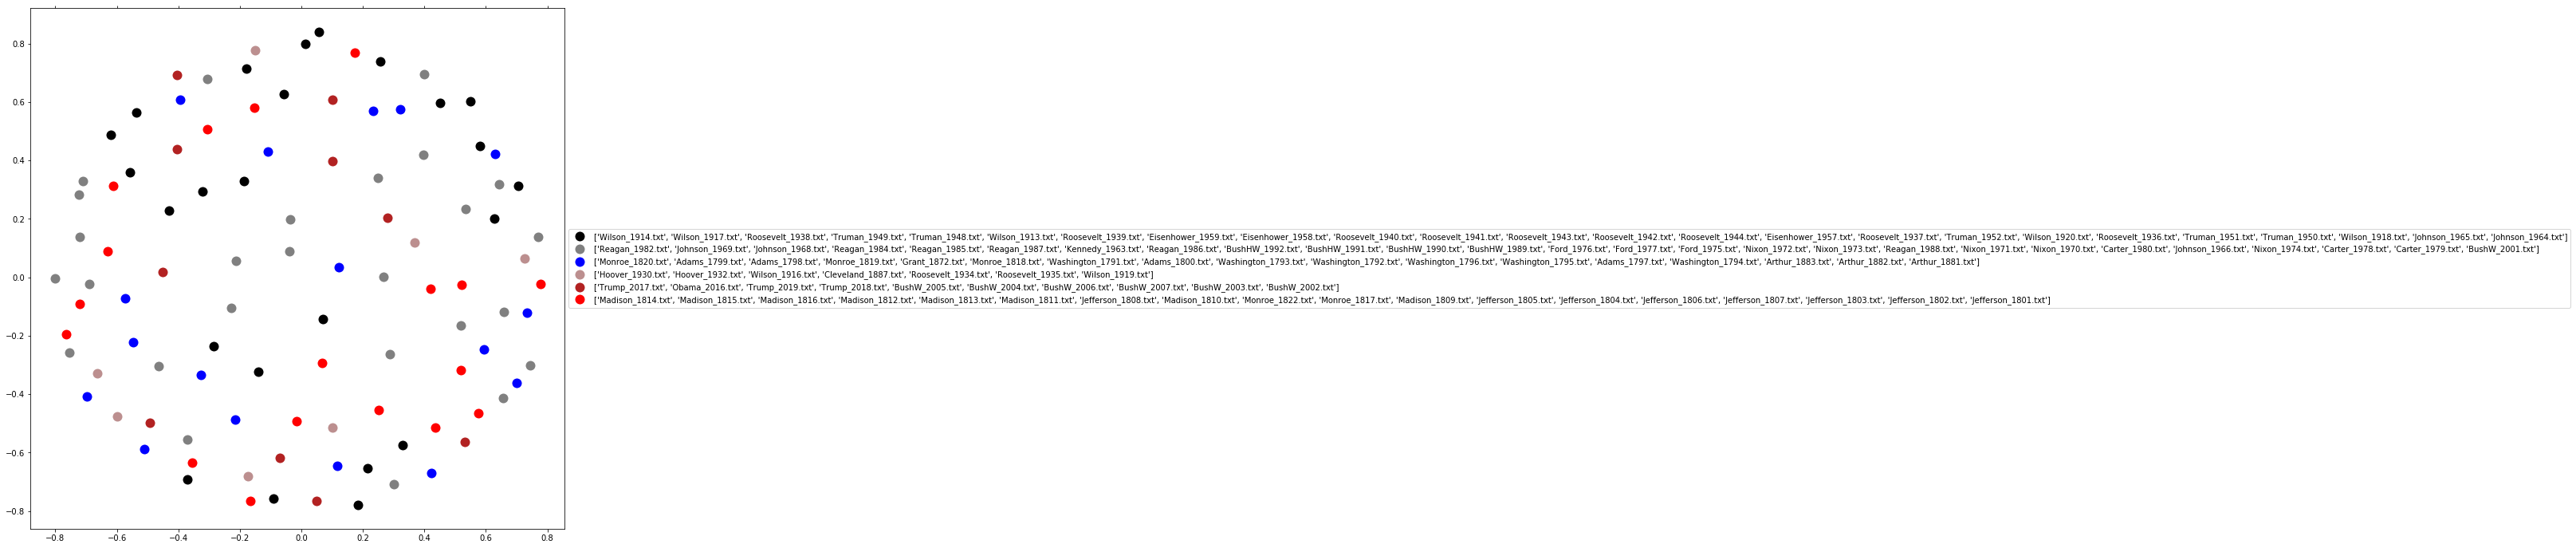

In [44]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 5:'red', 6:'darksalmon', 7:'sienna', 8:'green', 9:'purple', 10:'pink', 11:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

In [ ]:
# Creating dataframe from CV Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,3))
cv_matrix=cv.fit_transform(final_processed_text)    
cv_matrix=pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names(), index=titles)   

### Classification using various RF Model

The following section is used to create a model to predict the clusters labels based on the the TFIDF matrix and the doc2vec vectors.  

Note the model performance using the two different vectorization methods.

In [45]:
model_RF=RandomForestClassifier()

#TFIDF
Y=clusters
X=TFIDF_matrix

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=5)

#mean CV score
np.mean(cv_score)

#Doc2Vec
Y=clusters_d2v
X=doc2vec_k_means

#cross validation
cv_score=cross_val_score(model_RF, X, Y, cv=5)

#mean CV score
np.mean(cv_score)

0.7833333333333334

0.3638095238095238

In [46]:
# Trying few things out (Ali)

# Create transposed dataframe from CV Matrix
matrix_corp_t = matrix.transpose()
cv_matrix_corp_t = cv_matrix.transpose() 

# Sum all the terms to create Term Frequency and Document Frequency for each term
cv_matrix_corp_t['df_corpus']= (cv_matrix_corp_t != 0).sum(axis=1)
cv_matrix_corp_t['tf_corpus']= cv_matrix_corp_t.sum(axis=1) - cv_matrix_corp_t['df_corpus']

# Remove uncessary columns from the dataframe after summing them
idx = np.r_[0:102]
cv_matrix_corp_t.drop(cv_matrix_corp_t.columns[idx], axis=1, inplace=True)

print("Top 10 Terms based on document frequency.")
print(cv_matrix_corp_t[['df_corpus']].nlargest(10, 'df_corpus'))
print("\n")
print("Top 10 Terms based on frequency.")
print(cv_matrix_corp_t[['tf_corpus']].nlargest(10, 'tf_corpus'))

Top 10 Terms based on document frequency.
          df_corpus
state            98
power            97
peace            95
force            93
interest         93
public           93
policy           90
citizen          89
progress         89
system           89


Top 10 Terms based on frequency.
          tf_corpus
peace           709
power           533
program         482
public          479
force           463
security        433
citizen         421
federal         413
million         408
economic        399


## LSA

In [48]:
import seaborn as sns
from textblob import TextBlob

#year, pres, party, tokens

ModuleNotFoundError: No module named 'textblob'

In [62]:
for col in data.columns: 
    print(col) 

Text
President_Name
Year_SOTU
party


In [63]:
data_sa = data

In [64]:
data_sa.head()

,Text,President_Name,Year_SOTU,party
0,"Mr. Speaker, Mr. President, distinguished Memb...",Reagan,1982,Republican
1,GENTLEMEN OF THE CONGRESS: The session upon w...,Wilson,1914,Democrat
2,Fellow-Citizens of the Senate and House of Rep...,Madison,1814,Republican
3,"Mr. Speaker, Mr. President, Members of the Con...",Johnson,1969,Democrat
4,To the Senate and House of Representatives: I...,Hoover,1930,Republican


In [52]:
data_sa.drop(['Unnamed: 0', 'DSI_Title'], axis=1, inplace=True)

In [53]:
# Modify dataframe
data_sa['Year_SOTU'] = data_sa['Year_SOTU'].astype(int)
#df['President_Name'] = potus

#create a list of Democrat presidents
dems = ['Cleveland', 'Johnson', 'Wilson', 'Roosevelt', 'Truman', 'Kennedy', 'Carter', 'Obama']

#add party affiliation to the dataframe
data_sa['party'] = data_sa.President_Name.apply(lambda x: 'Democrat' if x in dems else 'Republican')

In [54]:
data_sa = data_sa[['Year_SOTU', 'President_Name', 'party', 'Text']]

In [55]:
data_sa.rename(columns={'Year_SOTU':'year', 'President_Name':'president', 'Text':'text'}, inplace=True)

In [56]:
data_sa.head()

,year,president,party,text
0,1982,Reagan,Republican,"Mr. Speaker, Mr. President, distinguished Memb..."
1,1914,Wilson,Democrat,GENTLEMEN OF THE CONGRESS: The session upon w...
2,1814,Madison,Republican,Fellow-Citizens of the Senate and House of Rep...
3,1969,Johnson,Democrat,"Mr. Speaker, Mr. President, Members of the Con..."
4,1930,Hoover,Republican,To the Senate and House of Representatives: I...


In [57]:
#use textblob to perform a sentiment analysis of each speech
data_sa['sentiment'] = data_sa['text'].apply(lambda speech: TextBlob(speech).sentiment.polarity)

NameError: name 'TextBlob' is not defined

Text(0.5, 20.80000000000002, 'Year')

Text(27.423986111111105, 0.5, 'Sentiment')

Text(0.5, 1, 'SotU Sentiment Analysis by President')

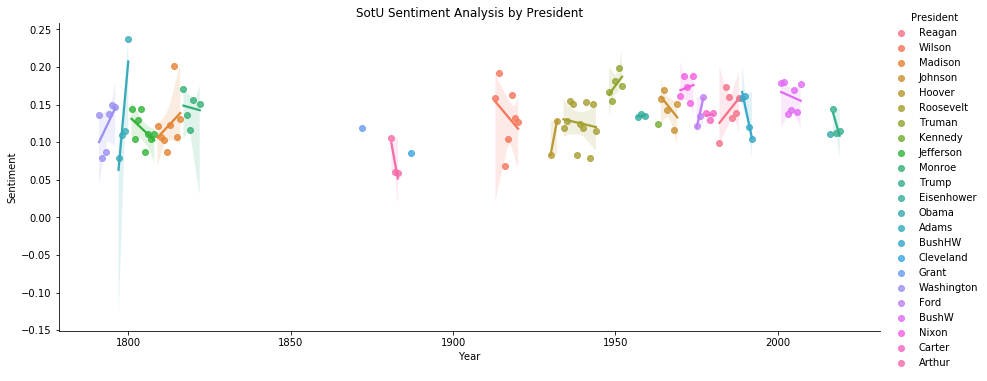

In [19]:
#plot sentiment analysis data
g = sns.lmplot(x="year", y="sentiment", hue="president", aspect=2.5, truncate=True, data=data_sa)
g._legend.set_title('President')
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.title('SotU Sentiment Analysis by President')

plt.show()

In [58]:
economic_df = pd.read_csv("/Users/mk1989f_a/Documents/Mitch/Github/NU_453_NLP/Data/gdp_data.csv")

FileNotFoundError: [Errno 2] File b'/Users/mk1989f_a/Documents/Mitch/Github/NU_453_NLP/Data/gdp_data.csv' does not exist: b'/Users/mk1989f_a/Documents/Mitch/Github/NU_453_NLP/Data/gdp_data.csv'

In [59]:
data_sa = data_sa.merge(economic_df, how='left', on='year')

NameError: name 'economic_df' is not defined

In [60]:
data_sa.rename(columns={'GDP Growth Rate':'gdp_rate'}, inplace=True)

In [61]:
data_sa.head()

,year,president,party,text
0,1982,Reagan,Republican,"Mr. Speaker, Mr. President, distinguished Memb..."
1,1914,Wilson,Democrat,GENTLEMEN OF THE CONGRESS: The session upon w...
2,1814,Madison,Republican,Fellow-Citizens of the Senate and House of Rep...
3,1969,Johnson,Democrat,"Mr. Speaker, Mr. President, Members of the Con..."
4,1930,Hoover,Republican,To the Senate and House of Representatives: I...


Text(0.5, 20.80000000000002, 'Year')

Text(26.741885416666676, 0.5, '% GDP Growth Rate')

Text(0.5, 1, 'GDP Growth Rate by Year')

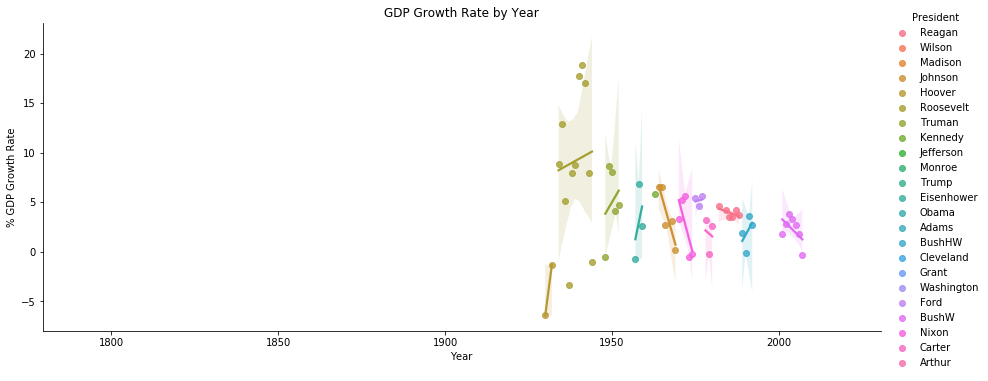

In [24]:
#plot GDP growth data
g1 = sns.lmplot(x="year", y="gdp_rate", hue="president", aspect=2.5, truncate=True, data=data_sa)
g1._legend.set_title('President')
plt.xlabel('Year')
plt.ylabel('% GDP Growth Rate')
plt.title('GDP Growth Rate by Year')

plt.show()

## Term Frequency by Decade


In [254]:
# Create copy of Matrix 
matrix_decade = matrix
matrix_decade.index.name = ''
# matrix_decade.head(10)

# Rename Index
matrix_decade.index.name = "DSI_Title"

# Reset Index
matrix_decade = matrix_decade.reset_index()

In [255]:
# Parse string to turn year of SOTU speech to a decade format
matrix_decade['DSI_Title'] = matrix_decade.DSI_Title.str.replace(r"[a-zA-Z._]",'')
matrix_decade['DSI_Title'] = matrix_decade['DSI_Title'].str.slice(0,3)
matrix_decade['DSI_Title'] = matrix_decade['DSI_Title'] + '0'

In [257]:
# Group and sum the terms by decade of SOTU speech
matrix_decade_t = matrix_decade_t.groupby(axis=1, level=0).sum()
matrix_decade_t.head()

DSI_Title,1790,1800,1810,1820,1870,1880,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
abandon,0.020212,0.027714,0.011185,0.0,0.0,0.0,0.000000,0.0,0.046886,0.033482,0.027883,0.037697,0.015279,0.031952,0.01687,0.047179,0.000000
abandon iraqi,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.040225,0.000000
abandoned,0.026258,0.021926,0.032376,0.0,0.0,0.0,0.014363,0.0,0.020627,0.017222,0.000000,0.000000,0.000000,0.086344,0.00000,0.013106,0.000000
abandoning,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.028372,0.019152,0.017800,0.020003,0.000000,0.00000,0.017170,0.000000
abandonment,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.020174,0.000000,0.026158,0.00000,0.000000,0.020806


In [258]:
# Create dataframe for each decade for further analysis

matrix_decade_1790 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1790'])
matrix_decade_1790 = matrix_decade_1790.loc[:, ['1790']]
matrix_decade_1790

matrix_decade_1800 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1800'])
matrix_decade_1800 = matrix_decade_1800.loc[:, ['1800']]
matrix_decade_1800

matrix_decade_1810 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1810'])
matrix_decade_1810 = matrix_decade_1810.loc[:, ['1810']]
matrix_decade_1810

matrix_decade_1820 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1820'])
matrix_decade_1820 = matrix_decade_1820.loc[:, ['1820']]
matrix_decade_1820

matrix_decade_1870 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1870'])
matrix_decade_1870 = matrix_decade_1870.loc[:, ['1870']]
matrix_decade_1870

matrix_decade_1880 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1880'])
matrix_decade_1880 = matrix_decade_1880.loc[:, ['1880']]
matrix_decade_1880

matrix_decade_1910 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1910'])
matrix_decade_1910 = matrix_decade_1910.loc[:, ['1910']]
matrix_decade_1910

matrix_decade_1920 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1920'])
matrix_decade_1920 = matrix_decade_1920.loc[:, ['1920']]
matrix_decade_1920

matrix_decade_1930 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1930'])
matrix_decade_1930 = matrix_decade_1930.loc[:, ['1930']]
matrix_decade_1930

matrix_decade_1940 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1940'])
matrix_decade_1940 = matrix_decade_1940.loc[:, ['1940']]
matrix_decade_1940

matrix_decade_1950 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1950'])
matrix_decade_1950 = matrix_decade_1950.loc[:, ['1950']]
matrix_decade_1950

matrix_decade_1960 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1960'])
matrix_decade_1960 = matrix_decade_1960.loc[:, ['1960']]
matrix_decade_1960

matrix_decade_1970 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1970'])
matrix_decade_1970 = matrix_decade_1970.loc[:, ['1970']]
matrix_decade_1970

matrix_decade_1980 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1980'])
matrix_decade_1980 = matrix_decade_1980.loc[:, ['1980']]
matrix_decade_1980

matrix_decade_1990 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1990'])
matrix_decade_1990 = matrix_decade_1990.loc[:, ['1990']]
matrix_decade_1990

matrix_decade_2000 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['2000'])
matrix_decade_2000 = matrix_decade_2000.loc[:, ['2000']]
matrix_decade_2000

matrix_decade_2010 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['2010'])
matrix_decade_2010 = matrix_decade_2010.loc[:, ['2010']]
matrix_decade_2010

DSI_Title,1790
commissioner,0.745489
gentleman,0.680769
treaty,0.582137
indian,0.545817
provision,0.457684
object,0.441683
gentleman house,0.385863
gentleman house representative,0.385863
measure,0.384137
subject,0.380864


DSI_Title,1800
vessel,0.687363
commerce,0.506430
principal,0.440128
million,0.431849
legislature,0.413740
subject,0.397509
consideration,0.378606
harbor,0.362904
mississippi,0.341458
circumstance,0.339085


DSI_Title,1810
british,0.901649
spain,0.711338
enemy,0.576784
tribe,0.548927
savage,0.504160
subject,0.493134
commerce,0.477132
militia,0.475240
treasury,0.457000
million,0.440538


DSI_Title,1820
spain,0.187583
likewise,0.161634
colony,0.155728
vessel,0.147232
proper,0.146356
coast,0.137535
extent,0.120394
object,0.117039
amount,0.117013
respecting,0.116729


DSI_Title,1870
award,0.218389
majesty,0.189122
treaty,0.174339
tribunal,0.119398
possession,0.119331
britain,0.118718
arbitrator,0.116099
appreciation,0.103025
exposition,0.103025
territory,0.100902


DSI_Title,1880
treaty,0.374940
tariff,0.347007
chile,0.302825
diplomatic,0.238083
bond,0.215774
consular,0.215289
mexico,0.212418
sinking,0.209478
relation,0.206098
convention,0.205657


DSI_Title,1910
matter,0.456942
railway,0.298834
interstate,0.295020
action,0.294949
thought,0.277889
legislation,0.266184
business,0.264270
german,0.258868
labor,0.250821
railroad,0.243361


DSI_Title,1920
faith,0.164244
democracy,0.149965
faith faith,0.143095
floating,0.124247
storage,0.119749
expenditure,0.092838
treasury,0.092838
serviceable,0.085857
receipt,0.085217
interstate,0.077663


DSI_Title,1930
recovery,0.476725
economic,0.472619
democracy,0.459567
problem,0.459222
relief,0.449783
federal,0.449406
industrial,0.389581
income,0.353952
employment,0.349091
business,0.341471


DSI_Title,1940
production,0.532382
economic,0.442510
japanese,0.414882
fighting,0.377593
living,0.335814
group,0.327855
program,0.317090
price,0.306092
hitler,0.285920
standard living,0.284569


DSI_Title,1950
economic,0.552397
program,0.517283
defense,0.483081
strength,0.468681
soviet,0.457988
effort,0.423266
communist,0.322812
economy,0.307564
development,0.305736
production,0.281672


DSI_Title,1960
vietnam,0.709187
program,0.597294
billion,0.573696
budget,0.346598
propose,0.327926
poverty,0.322630
communist,0.321650
president,0.312433
effort,0.288868
increase,0.276073


DSI_Title,1970
program,1.013689
federal,1.003412
inflation,0.647410
energy,0.643387
president,0.577831
budget,0.500416
spending,0.453637
major,0.445239
economic,0.436382
nuclear,0.432860


DSI_Title,1980
soviet,0.837238
budget,0.697111
family,0.635176
program,0.607657
federal,0.530553
child,0.524216
deficit,0.486227
growth,0.469834
economic,0.456489
spending,0.445043


DSI_Title,1990
child,0.265387
investment,0.219401
budget,0.210155
family,0.210013
federal,0.178893
missile,0.173006
century,0.169403
thing,0.168422
school,0.162110
growth,0.158592


DSI_Title,2000
terrorist,1.199205
iraqi,0.818898
child,0.632386
terror,0.618805
health,0.492077
regime,0.467891
weapon,0.460757
social security,0.436670
reform,0.429115
medicare,0.406146


DSI_Title,2010
family,0.310719
immigration,0.308706
worker,0.274086
infrastructure,0.246153
terrorist,0.244013
border,0.239797
child,0.239058
company,0.231310
incredible,0.207872
immigrant,0.200306


In [263]:
# Merge dataframes into one table to show overlaps between decades
matrix_decade_merge = pd.concat([matrix_decade_1790, matrix_decade_1800, matrix_decade_1810, matrix_decade_1820, matrix_decade_1870, matrix_decade_1880, matrix_decade_1910, matrix_decade_1920, matrix_decade_1930, matrix_decade_1940, matrix_decade_1950, matrix_decade_1960, matrix_decade_1970, matrix_decade_1980, matrix_decade_1990, matrix_decade_2000, matrix_decade_2010], axis=1, sort=False)

# Replace NaN values with 0
matrix_decade_merge = matrix_decade_merge.replace(np.nan,0)

# Round numbers to 3 decimal places
matrix_decade_merge = matrix_decade_merge.round(decimals=3)

In [264]:
matrix_decade_merge

DSI_Title,1790,1800,1810,1820,1870,1880,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
commissioner,0.745,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
gentleman,0.681,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
treaty,0.582,0.000,0.000,0.000,0.174,0.375,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
indian,0.546,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
provision,0.458,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
object,0.442,0.000,0.000,0.117,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
gentleman house,0.386,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
gentleman house representative,0.386,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
measure,0.384,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
subject,0.381,0.398,0.493,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


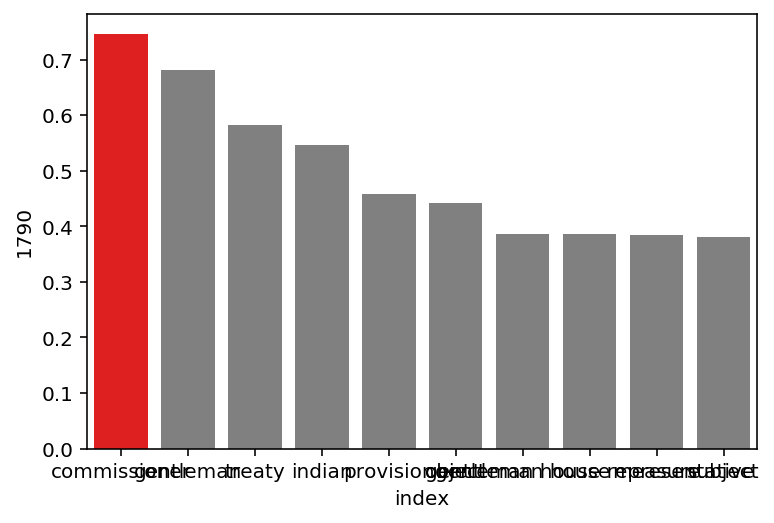

In [325]:
clrs = ['grey' if (x < max(matrix_decade_1790['1790'])) else 'red' for x in matrix_decade_1790['1790']]
sns.barplot(data = matrix_decade_1790.reset_index(), x='index',y='1790', palette=clrs)

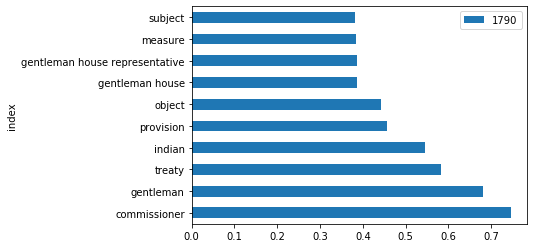

In [287]:
matrix_decade_1790.reset_index().plot(kind='barh', x='index', y='1790')